C:\Users\sinha\.conda\envs\qiskit\Lib\site-packages\qiskit_algorithms\amplitude_estimators\ae.py:291: UserWarning: No sampler provided, defaulting to Sampler from qiskit.primitives
  warnings.warn("No sampler provided, defaulting to Sampler from qiskit.primitives")


Data Point 1: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 2: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 3: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 4: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 5: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 6: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 7: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 8: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 9: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 10: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 11: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 12: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 13: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 14: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data Point 15: Classical Power = 0.0000 W, QAE Estimation = 1.0000
Data

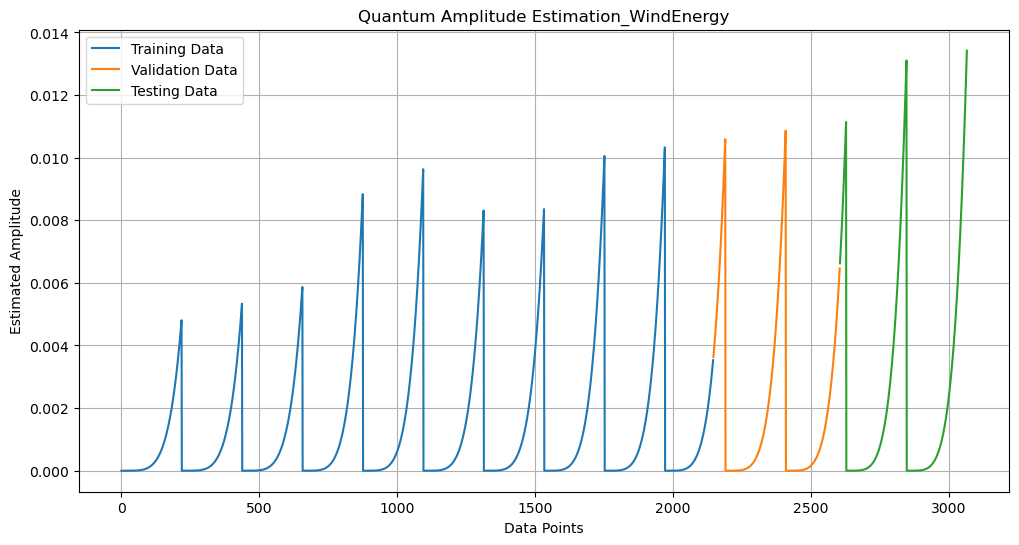

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import QFT
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Constants
eta = 0.3
E = 70 * 10**9  # Pascal
rho = 1.225  # kg/m^3
pi = np.pi

# Load data from CSV
data = pd.read_csv("E:/Solar and Wind Integration/Second Paper/wind_turbine_data.csv")
v = data['v'].values
H = data['H'].values
L = data['L'].values
D_outer = data['D_outer'].values
D_inner = data['D_inner'].values
d = data['d'].values

# Objective function to calculate Power (P)
def calculate_power(v, H, L, D_outer, D_inner, d):
    term1 = (rho ** 2) * (v ** 5) * (D_outer ** 2)
    term2 = ((H - (L / 2)) ** 2) * (L ** 2)
    denominator = 12 * E * ((pi / 64) * ((D_outer ** 4) - (D_inner ** 4)) * d)
    return eta * (term1 * term2) / denominator

# Improved state preparation to encode power output
def power_to_rotation_angle(power):
    # Normalize power to a range between 0 and pi (this can be adjusted)
    max_power = np.max(powers) if len(powers) > 0 else 1
    return np.arcsin(np.clip(power / max_power, 0, 1))

# Define Quantum Circuit for Amplitude Estimation with Power Encoding
def quantum_amplitude_estimation(power):
    num_eval_qubits = 3  # Number of qubits used for amplitude evaluation
    num_qubits = 3  # Number of qubits for the state preparation circuit

    # Create a quantum circuit for amplitude estimation (state preparation)
    qae_circuit = QuantumCircuit(num_qubits)

    # Apply Hadamard to the first two qubits
    for qubit in range(num_qubits - 1):
        qae_circuit.h(qubit)

    # Encode power into a rotation on the last qubit
    angle = power_to_rotation_angle(power)
    qae_circuit.ry(2 * angle, num_qubits - 1)

    # State preparation is done; now we can define the estimation problem
    estimation_problem = EstimationProblem(state_preparation=qae_circuit, objective_qubits=[num_qubits - 1])

    # Initialize AmplitudeEstimation with the number of evaluation qubits
    ae = AmplitudeEstimation(num_eval_qubits=num_eval_qubits)

    # Use AerSimulator for running the estimation
    simulator = AerSimulator()
    result = ae.estimate(estimation_problem)

    return result

# Variables to track optimum values
optimum_power = -np.inf
optimum_index = -1

# Iterate over the data points and maximize the objective function P
powers = []
for i in range(len(v)):
    # Classical calculation of power
    P_classical = calculate_power(v[i], H[i], L[i], D_outer[i], D_inner[i], d[i])
    powers.append(P_classical)

    # Run Quantum Amplitude Estimation (QAE)
    result = quantum_amplitude_estimation(P_classical)

    qae_value = result.estimation  # Extract the estimated value from the result

    #print(f"Data Point {i+1}: Classical Power = {P_classical:.4f} W, QAE Estimation = {qae_value:.4f}")

    # Track the optimum value
    if P_classical > optimum_power:
        optimum_power = P_classical
        optimum_index = i

# Display the data point corresponding to the optimum value
#print(f"\nOptimum power is {optimum_power:.4f} W achieved at data point {optimum_index+1}:")
print(f"v = {v[optimum_index]:.4f}, H = {H[optimum_index]:.4f}, L = {L[optimum_index]:.4f}, D_outer = {D_outer[optimum_index]:.4f}, D_inner = {D_inner[optimum_index]:.4f}, d = {d[optimum_index]:.4f}")

# Splitting the data into training, validation, and testing sets
train_size = int(0.7 * len(powers))
val_size = int(0.15 * len(powers))

train_powers = powers[:train_size]
val_powers = powers[train_size:train_size + val_size]
test_powers = powers[train_size + val_size:]

# Visualize and save the output
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_powers)), train_powers, label='Training Data')
plt.plot(range(len(train_powers), len(train_powers) + len(val_powers)), val_powers, label='Validation Data')
plt.plot(range(len(train_powers) + len(val_powers), len(powers)), test_powers, label='Testing Data')
plt.title('Quantum Amplitude Estimation_WindEnergy')
plt.xlabel('Data Points')
plt.ylabel('Estimated Amplitude')
plt.legend()
plt.grid(True)

# Save the graph as .svg
plt.savefig('qae_power_output_wind_final.svg', dpi=300)
plt.show()
